### DCC-GARCH MODEL

$$r_t|\Omega_{t-1} \sim N(0,H_t)$$
其中：
$$H_t = D_tR_tD_t, D_t = diag\{\sigma_{1,t},\sigma_{2,t},\cdots,\sigma_{n,t}\}$$
#### 对每个资产单独拟合GARCH(1，1)模型

$$\sigma_{i,t}^2 = \alpha_i + \beta_{i,1}r_{i,t-1}^2 + \beta_{i,2}\sigma_{i,t-1}^2$$
$$\epsilon_{i,t} = r_{i,t}/\sigma_{i,t}$$

#### 对资产相关系数拟合GARCH(1，1)模型
$$q_{ij,t} = \bar{\rho_{ij}} + a(\epsilon_{i,t-1}\epsilon_{j,t-1}) + b(q_{ij,t-1}-\bar{\rho_{ij}})$$
##### 标准化
$$\rho_{ij,t} = \frac{q_{ij,t}}{\sqrt{q_{ii,t}q_{jj,t}}} $$
$$Q_t = {q_{ij,t}}$$
$$R_t = \Theta_tQ_t\Theta_t, 其中\Theta_t=diag\{\frac{1}{\sqrt{q_{11,t}}},\frac{1}{\sqrt{q_{22,t}}},\cdots,\frac{1}{\sqrt{q_{nn,t}}}\}$$

#### 对数似然函数
$$L = -\frac{1}{2}\sum_{t=1}^{T}(nln(2\pi) + ln|H_t| + r_t^TH_t^{-1}r_t) = L_1+L_2$$
$$L_1 = -\frac{1}{2}\sum_{t=1}^{T}(nln(2\pi) + ln|D_t| + r_t^TD_t^{-2}r_t)$$
$$L_2 = -\frac{1}{2}\sum_{t=1}^{T}(\epsilon_t^T\epsilon_t + ln|R_t| + \epsilon_t^TR_t^{-1}\epsilon_t)$$

可以看到似然函数$L$可以拆分成两部分$L_1和L_2$，所以很自然的可以将最大似然法拆分成两步来完成所有参数的估计。
##### 第一步
观察$L_1$可以发现，其事实上就是不考虑动态相依性，单独拟合各资产的GARCH(1,1)模型，最大化$L_1$。【scalar】
##### 第二步
通过第一步可以得到$\epsilon_t$,然后最大化$L_2$,得到DCC的参数估计【matrix】。由于$\epsilon_t$可以当做已知序列，所以$L_2$进一步简化为:
$$L_2 = -\frac{1}{2}\sum_{t=1}^{T}(ln|R_t| + \epsilon_t^TR_t^{-1}\epsilon_t)$$

In [1]:
import sys
path = r'D:\Program Files\Anaconda\QieCode\PSO'
sys.path.append(path)
from pso import pso

In [2]:
%load_ext Cython

### <font color='#ff2222' face='微软雅黑'>第一步：对每只资产分别拟合GARCH模型</font>

- 算得的标准化残差$\epsilon$在第二步拟合DCC模型时使用
- 算得的历史波动率及波动率一步预测可以用来预测下一日的CVaR和VaR。更进一步的，在DCC模型求得相关系数后，可以求得资产组合的CVaR和VaR


In [3]:
%%file likelihood_s.pyx
import numpy as np
from libc.math cimport log, sqrt
import sys
path = r'D:\Program Files\Anaconda\QieCode\PSO'
sys.path.append(path)
from pso import pso

cdef class garchScalar:
    '''
    garchScalar：一元(标量)GARCH模型                 
    ================================
                 通过传入的残差序列建立garchScalar对象，调用train()方法训练模型，
                 调用predict方法可以做向前一步预测。
                 参数中，标准化残差序列epsilon在计算VaR和CVaR时会用到。
    Attributes:
    ===========
       ret: 收益率序列
         a: 残差序列，通过_calcResidual()获取，可以改写该方法，
            譬如用ARMA(p,q)模型求取残差
       var: 样本内方差序列
    params: 模型参数
            [0] phi: 截距
            [1] alpha: ma项系数
            [2] beta: ar项系数
            [3] var_init: 初始方差
    epsilon: 标准化残差序列,epsilon[t] = ret[t] / sqrt(var[t])
    
    Methods
    =======
    注：cdef定义的函数只能被Cython调用，不能被Python调用。cpdef定义的函数即可
        被Cython又可被Python调用
    [0] _calcResidual: 由收益率序列计算残差序列
    [1] _calcVarInit: 内部方法，计算残差序列的方差作为方差序列初始值
    [2] likelihood_s: 传入params，计算对数似然函数（事实上是对数似然函数的相反数）
    [3] _calcVarSeries: 内部方法，利用已经优化好的参数计算样本内方差序列
    [4] _calcEpsilon: 内部方法，根据epsilon的计算公式计算epsilon序列
    [5] train: 训练模型，并计算var和epsilon
    [6] predict: 向前一步预测
    '''
    cdef:
        public double[:] ret
        public double[:] a
        public double[:] var
        public double[:] params
        public double[:] epsilon
        int T

    def __init__(self,double[:] ret):
        self.ret = ret
        self.T = self.ret.shape[0]
        self.a = self._calcResidual()        
        self.var = np.ones(self.T,dtype=np.double)*self._calcVarInit()
        self.epsilon = np.ones(self.T,dtype=np.double)
        self.params = np.random.rand(4)

    cdef double[:] _calcResidual(self):
        cdef:
            int t 
            double[:] tmp = np.empty(self.T)
            double mean = 0.0

        for t in range(self.T):
            mean += self.ret[t]
        mean /= <double>self.T
        for t in range(self.T):
            tmp[t] = self.ret[t] - mean
        return tmp
        
    cdef double _calcVarInit(self):
        '''计算残差序列的方差作为方差序列初始值'''
        cdef:
            int t
            double mu = 0.0
            double var = 0.0
        for t in range(self.T):
            mu += self.a[t]
        mu /= <double>self.T
        for t in range(self.T):
            var += (self.a[t]-mu)**2
        var /= <double>self.T
        return var
        
    cpdef double likelihood_s(self,double[:] params):
        '''
        传入params，计算对数似然函数（事实上是对数似然函数的相反数）
        '''
        cdef:
            double phi = params[0]
            double alpha = params[1]
            double beta = params[2]
            double var_init = params[3]
            double LL
            double[:] var_copy = self.var.copy()
            int t
            
        var_copy[0] = var_init
        LL = log(var_copy[0]) + self.a[0]**2/var_copy[0]
        for t in range(1,self.T):
            var_copy[t] = phi + alpha * (self.a[t-1]**2) + beta * var_copy[t-1]
            LL += log(var_copy[t]) + self.a[t]**2/var_copy[t]
        return LL   
    
    cdef _calcVarSeries(self):
        '''利用优化好的参数计算样本内方差序列'''
        cdef:
            int t
        self.var[0] = self.params[3]
        for t in range(1,self.T):
            self.var[t] = self.params[0] + self.params[1] * (self.a[t-1]**2)\
                          + self.params[2] * self.var[t-1]
                
    cdef _calcEpsilon(self):
        '''计算标准化残差'''
        cdef int t
        for t in range(self.T):
            self.epsilon[t] = self.a[t]/sqrt(self.var[t])

    cpdef train(self):
        '''
        TODO:可由train参数传入pso优化所需的参数
        '''
        cdef:
            double[:] lb = np.ones(4,dtype=np.double) * 1e-15
            double[:] ub = np.ones(4,dtype=np.double)
        ub[3] = self._calcVarInit()
        self.params, _ = pso(self.likelihood_s, lb, ub, swarmsize=100,particle_output=False)
        self._calcVarSeries()
        self._calcEpsilon()
    cpdef double predict(self):
        '''向前一步预测'''
        cdef double pred
        pred = self.params[0] + self.params[1] * (self.a[-1]**2)\
                          + self.params[2] * self.var[-1]
        return pred

Overwriting likelihood_s.pyx


In [4]:
%%file tailDistribution.pyx
import numpy as np
from libc.math cimport log
import sys
path = r'D:\Program Files\Anaconda\QieCode\PSO'
sys.path.append(path)
from pso import pso

cdef class tailDistribution:
    '''
    tailDistribution: 通过极值法拟合序列尾部分布，进而求取VaR和CVaR
    
    '''
    cdef:
        public long n,n_u
        public double alpha, u, beta, xi, var, cvar
        public double[::1] r
        
    def __init__(self, ret, alpha):
        self.n = len(ret) # 输入序列长度
        self.alpha = <double>alpha # 置信度
        r_st = np.sort(ret) # 将ret按升序排列
        self.n_u = <long>(self.n*(1.0-self.alpha)) # 尾部数据的截取点
        self.r = -1.0 * r_st[:self.n_u] # 截取最小的n_u个数并对它们取反
        self.u = self.r[-1] # 截取点处收益率的相反数
        self.beta = 0.0 # pareto分布参数
        self.xi = 0.0 # pareto分布参数
        self.var = 0.0 # VaR值
        self.cvar = 0.0 # CVaR值
        
    cpdef double ll(self,double[::1] params):
        '''对数似然函数（的相反数）'''
        cdef:
            double beta,xi,tmp
            int i
        beta, xi = params[0], params[1]
        tmp = 0.0
        for i in range(self.n_u):
            tmp += (1.0/xi + 1.0)*log(1.0+(self.r[i] - self.u)*xi/beta) + log(beta)
#             print 'num%d'%i,log(1+(self.r[i] - self.u)*float(xi)/beta),log(beta)
        return tmp

    cpdef train(self):
        cdef:
#             double[::1] params = np.random.rand(2)*np.array([200,1])
            double[::1] ub = np.array([200.0, 1.0])
            double[::1] lb = np.array([1.0e-10, 1.0e-10]) 
            tuple params_opt
        params_opt = pso(self.ll, lb, ub, swarmsize=200,particle_output=False)
        print 'L:',(-params_opt[1])
        self.beta = params_opt[0][0]
        self.xi = params_opt[0][1]
        
    cpdef double varCal(self,double q):
        cdef double tmp
        tmp = self.u + (((1.0-q)*self.n/self.n_u)**(-self.xi)-1.0) * self.beta/self.xi
        self.var = tmp
        return self.var
    
    cpdef double cvarCal(self, double q):
        cdef double tmp
        self.varCal(q)
        tmp = (self.var + self.beta - self.xi * self.u) / (1 - self.xi)
        self.cvar = tmp
        return self.cvar        

Overwriting tailDistribution.pyx


In [5]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x4260ba8>)

In [6]:
from likelihood_s import garchScalar
from tailDistribution import tailDistribution as tail

                bond     stock
2005-05-11  0.000857 -0.012375
2005-05-12 -0.000286 -0.017934
2005-05-13  0.001617  0.001940
2005-05-16  0.002184 -0.013921
2005-05-17  0.000284  0.007047


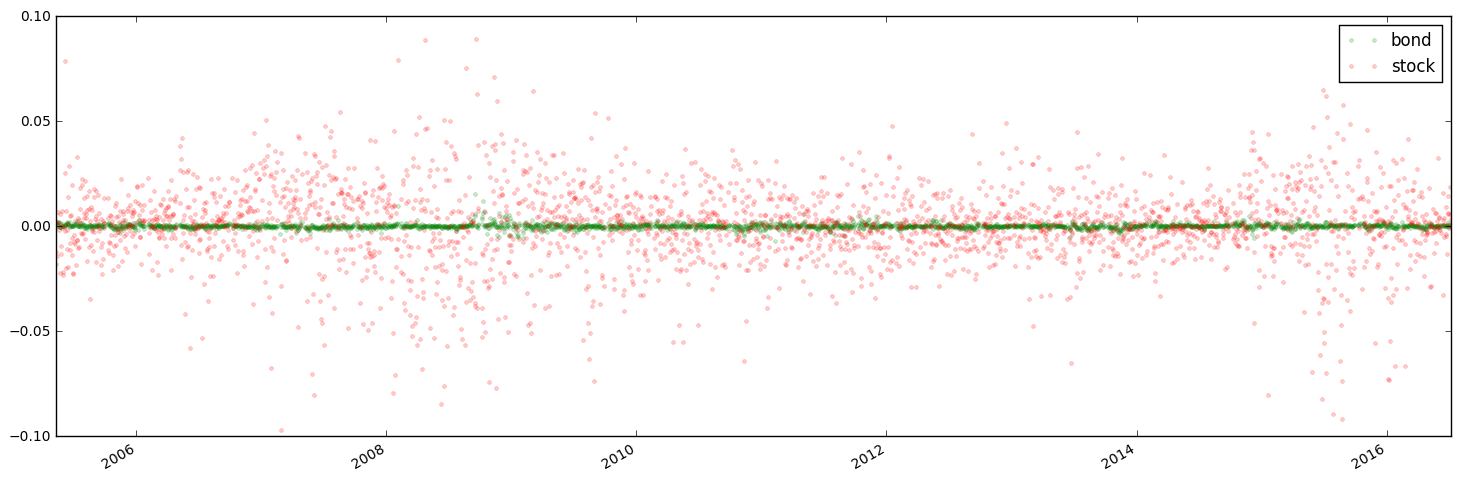

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import scipy.optimize as sco
%matplotlib inline

# load data
# 导入沪深300-macd.csv, 债券指数-bond.csv，计算收益率并存储在DataFrame r_both中
path_s = r'D:\PythonFiles\Python Data\macd.csv'
stock = pd.read_csv(path_s,parse_dates=0,index_col=0)['close_price']
r_s = np.log(stock/stock.shift(1)).dropna()
path_b = r'D:\PythonFiles\Python Data\bond.csv'
bond = pd.read_csv(path_b,parse_dates=1,index_col=1)['closeIndex']
r_b = np.log(bond/bond.shift(1)).dropna()
r_b = r_b[r_s.index].dropna()
r_s = r_s[r_b.index]

# 将股债收益率序列存储到DataFrame中
r_both = pd.DataFrame({'stock':r_s, 'bond':r_b})

 # 做出收益率时间序列散点图
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(18,6))
r_both.plot(style=['g.','r.'],alpha=0.2,ax=ax)
print r_both.head()
# 数据规整与处理
def calcResid(r):
    '''
    input:
    ======
       r : pd.DataFrame
    
    output:
    =======
       a : pd.DataFrame
    mean : np.array
     cov : np.array
    '''
    mean = r.mean() # 收益率序列的均值
    a = r - mean # 收益率-均值=收益率残差序列
    cov = r.cov() # 计算收益率的协方差矩阵
    
    # 返回残差、收益率均值、协方差矩阵
    return a,mean,cov
a,mean,cov = calcResid(r_both)

[ 0.00011608  0.00011939  0.00013257 ...,  0.00012228  0.00013567
  0.0001302 ]
0.000123850242305


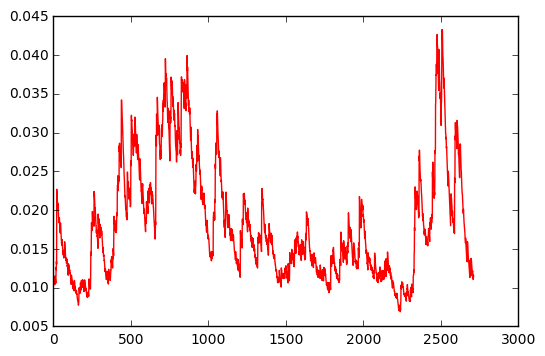

In [29]:
ret1 = r_both['stock'].values
a_garch = garchScalar(ret1)
a_garch.train()
print np.asarray(a_garch.var)
print a_garch.predict()
var = np.asarray(a_garch.var)
plt.plot(np.sqrt(var),color='r')

### <font color='#ff2222' face='微软雅黑'>求单只资产的CVaR</font>
求取标准化残差序列——$\epsilon_t = \frac{r_t}{\sigma_t}$得$CVaR_{norm}$，然后再乘以波动率的一步向前预测，可以得到预测的$CVaR_{pred}$
$$CVaR_{pred}=CVaR_{norm}\times\sigma_{T+1}$$


In [31]:
a_norm = r_both['stock'].values/np.sqrt(np.asarray(a_garch.var))
t = tail(a_norm,0.93)
t.train()
print t.cvarCal(0.99)*np.sqrt(a_garch.predict())

L: -126.680028188
0.0392956324944


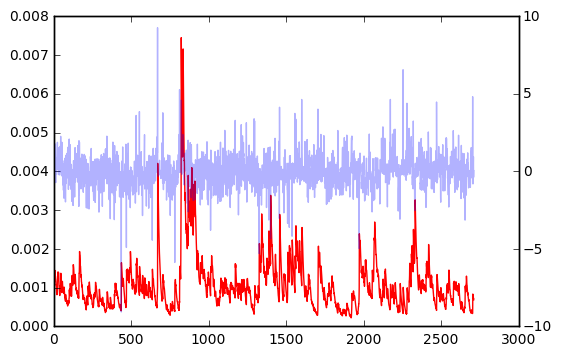

In [10]:
a1 = a['bond'].values
def trainGarchScalar(a):
    a_garch = garchScalar(a)
    a_garch.train()
    return np.asarray(a_garch.var),np.asarray(a_garch.epsilon)
var,epsilon = trainGarchScalar(a1)

plt.plot(np.sqrt(var),color='r')
ax = plt.gca()
ax2 = plt.twinx(ax)
plt.plot(epsilon,alpha=0.3)

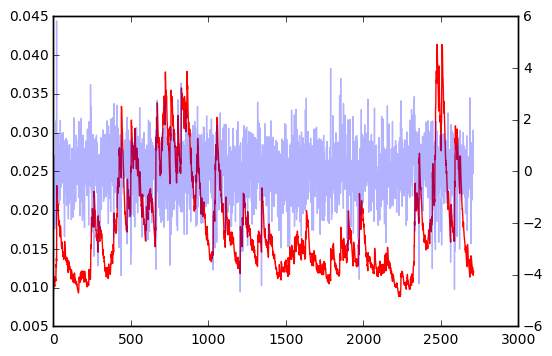

In [11]:
a2 = a['stock'].values
var,epsilon = trainGarchScalar(a2)
plt.plot(np.sqrt(var),color='r')
ax = plt.gca()
ax2 = plt.twinx(ax)
plt.plot(epsilon,alpha=0.3)

### <font color='#ff2222' face='微软雅黑'>DCC-GARCH第二步优化</font>
计算并最小化$L2$：
$$L_2 = -\frac{1}{2}\sum_{t=1}^{T}(ln|R_t| + \epsilon_t^TR_t^{-1}\epsilon_t)$$

### <font color='#ff2222' face='微软雅黑'>资产组合的CVaR</font>
优化可以得到时变相关系数矩阵序列$\rho_t$
设资产权重向量为$\omega=\{\omega_i\}$，前面计算的单只资产收益率的CVaR为$CVaR = \{CVaR_i\}$,则资产组合的CVaR为：
$$CVaR_{porfolio} = \sqrt{\eta^T\rho_t\eta}$$
其中$\eta_i = \omega_i\times{CVaR_i}$

In [97]:
%%cython
import numpy as np
cimport numpy as np
import sys
path = r'D:\Program Files\Anaconda\QieCode\PSO'
sys.path.append(path)
from pso import pso
from likelihood_s import garchScalar
from tailDistribution import tailDistribution as tail
from math import log

cdef class dccGarch():
    def __init__(self,rets):
        self.rets = rets
        self.T = rets.shape[0]
        self.K = rets.shape[1]
        self.Q = np.random.rand(self.T,self.K,self.K)
        self.R = np.random.rand(self.T,self.K,self.K)
        self.RHO = np.random.rand(self.K,self.K)
        self.E = np.random.rand(self.T,self.K,self.K)
        self.epsilon = np.random.rand(self.T,self.K)
        self.garch_s = []
        self.params = np.random.rand(2)
        self._fitGarchScalar()
    def _fitGarchScalar(self):
        for i in range(self.K):
            self.garch_s.append(garchScalar(self.rets[:,i]))
            self.garch_s[i].train()
            self.epsilon[:,i] = self.garch_s[i].epsilon
        self.E = self.epsilon[:,np.newaxis,:]*self.epsilon[:,:,np.newaxis]
        self.RHO = self.E.sum(axis=0)/self.T
    def likelihood(self,params):
        alpha,beta = params[0],params[1]
        Q = np.random.rand(self.T,self.K,self.K)
        R = np.random.rand(self.T,self.K,self.K)
        ll = 0
        for t in range(1,self.T):
            if t == 0:
                Q[t] = self.RHO
            else:
                Q[t] = (1-alpha-beta)*self.RHO + alpha*self.E[t-1] + beta*Q[t-1]
            lamb = np.diag(1/np.sqrt(np.diag(Q[t])))
            R[t] = np.dot(lamb,np.dot(Q[t],lamb))
            try:
                ll += log(np.linalg.det(R[t])) + np.dot(self.epsilon[t],
                                                        np.dot(np.linalg.inv(R[t]),
                                                               self.epsilon[t]))
            except:
                return 1e10
        return ll
    def updateQR(self):
        alpha,beta = self.params[0],self.params[1]
        for t in range(self.T):
            if t == 0:
                self.Q[t] = self.RHO
            else:
                self.Q[t] = (1-alpha-beta)*self.RHO + alpha*self.E[t-1] + beta*self.Q[t-1]
            lamb = np.diag(1/np.sqrt(np.diag(self.Q[t])))
            self.R[t] = np.dot(lamb,np.dot(self.Q[t],lamb))
    def train(self):
        lb = np.ones(2,dtype=np.double)*1e-15
        ub = np.ones(2,dtype=np.double)
        self.params,_ = pso(self.likelihood,lb,ub)
        self.updateQR()

In [98]:
dcc = dccGarch(r_both.values)
dcc.E

array([[[  6.10514038e-01,  -5.71212025e-01],
        [ -5.71212025e-01,   5.34440090e-01]],

       [[  3.15225602e-01,   5.95820283e-01],
        [  5.95820283e-01,   1.12618331e+00]],

       [[  3.09662231e+00,   1.53294575e-01],
        [  1.53294575e-01,   7.58866414e-03]],

       ..., 
       [[  8.97017280e-01,   1.51264656e+00],
        [  1.51264656e+00,   2.55078656e+00]],

       [[  1.42801375e-01,  -1.71375345e-01],
        [ -1.71375345e-01,   2.05666850e-01]],

       [[  2.61450745e-03,   1.36697916e-02],
        [  1.36697916e-02,   7.14716656e-02]]])

In [99]:
dcc.train()
print dcc.params

[ 0.01003855  0.27453505]


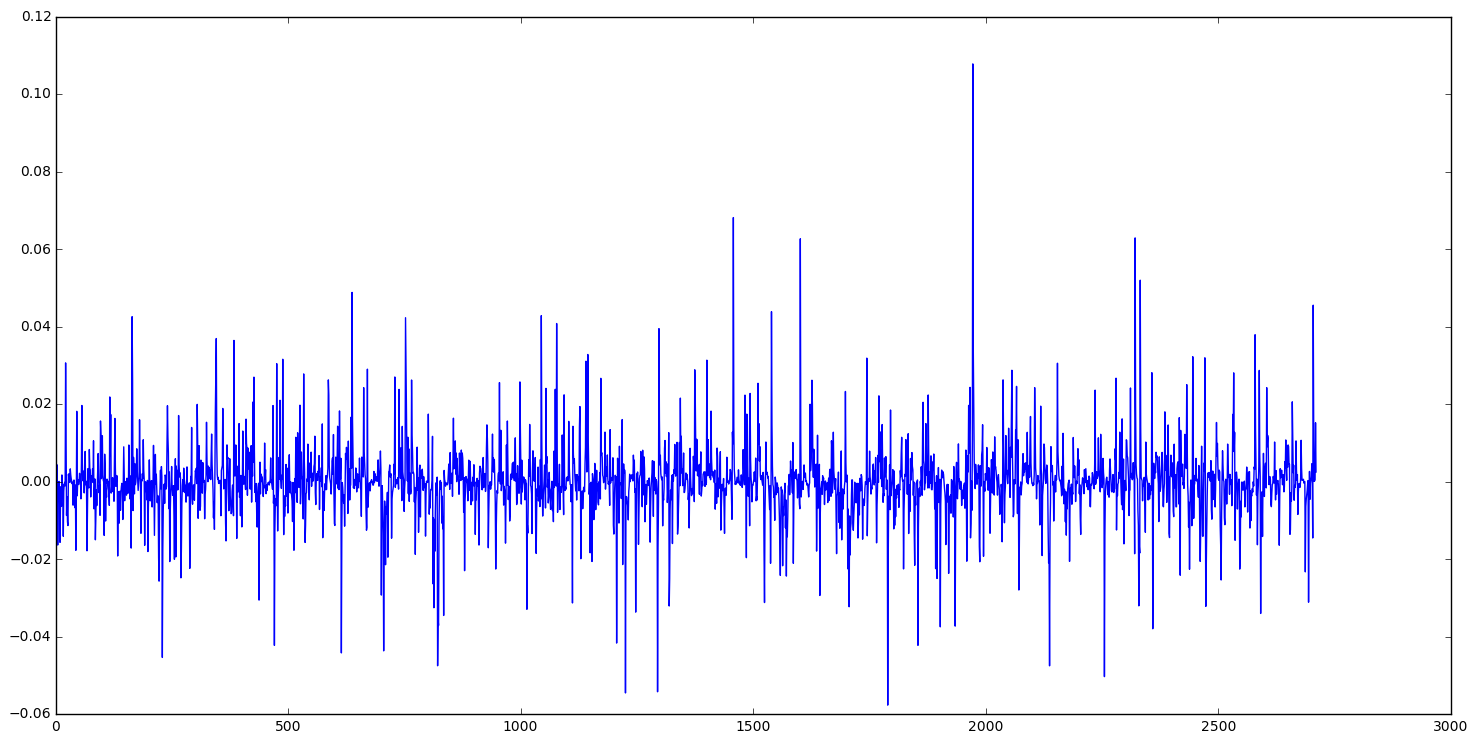

In [101]:
plt.figure(figsize=(18,9))
plt.plot(dcc.R[:,0,1])

<font color='#ff2222' face='微软雅黑'>DCC计算的结果似乎不是很好</font>